In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
import zarr
from matplotlib import pyplot
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

In [2]:
# Pupil plane
n_p = 32
size_p = 8.0
pitch_p = size_p / n_p
z_p = 0.0

# View plane
n_v = 1440
size_v = 360.0
pitch_v = size_v / n_v
z_v = 176.0

# Field of view
fov_factor = (size_v - size_p) / z_v
fov = 2 * np.arctan(fov_factor / 2) * 180/np.pi

# Retina estimate
lf_n_r = n_v - n_p

print('[Sampled Light Field]')
print('Pupil Plane:     {:4} × {:4.2f} mm = {:5} mm         \t    z_p = {:5} mm'.format(n_p, pitch_p, size_p, z_p))
print('View Plane:      {:4} × {:4.2f} mm = {:5} mm         \t    z_v = {:5} mm'.format(n_v, pitch_v, size_v, z_v))
print('Retina Estimate: {:7.2f} samples over FoV = {:4.1f}° \t z_near = {:5} mm'.format(lf_n_r, fov, z_v/2))

print('\nNumber of rays: {:,}'.format((n_p * n_v)**2))

[Sampled Light Field]
Pupil Plane:       32 × 0.25 mm =   8.0 mm         	    z_p =   0.0 mm
View Plane:      1440 × 0.25 mm = 360.0 mm         	    z_v = 176.0 mm
Retina Estimate: 1408.00 samples over FoV = 90.0° 	 z_near =  88.0 mm

Number of rays: 2,123,366,400


In [3]:
# Plane A
n_a = 48
z_a = 8.0
size_a = size_p + fov_factor * z_a
pitch_a = size_a / n_a

# Plane B
n_b = 560
z_b = 136.0
size_b = size_p + fov_factor * z_b
pitch_b = size_b / n_b

# Retina estimate
ab_n_r = fov_factor * (z_b - z_a) / max(pitch_a, pitch_b)

print('[Display Light Field]')
print('Plane A:         {:4} × {:4.2f} mm = {:5} mm         \t    z_a = {:5} mm'.format(n_a, pitch_a, size_a, z_a))
print('Plane B:         {:4} × {:4.2f} mm = {:5} mm         \t    z_b = {:5} mm'.format(n_b, pitch_b, size_b, z_b))
print('Retina Estimate: {:7.2f} samples over FoV = {:4.1f}° \t z_near = {:5} mm'.format(ab_n_r, fov, z_b/2))

print('\nNumber of elements: {:,}'.format((n_a * n_b)**2))

[Display Light Field]
Plane A:           48 × 0.50 mm =  24.0 mm         	    z_a =   8.0 mm
Plane B:          560 × 0.50 mm = 280.0 mm         	    z_b = 136.0 mm
Retina Estimate:  512.00 samples over FoV = 90.0° 	 z_near =  68.0 mm

Number of elements: 722,534,400


In [4]:
def array_stats(a):
    print('{} × {} = {} GiB | min: {}, avg: {}, max: {}'.format(a.shape, a.dtype, a.nbytes/2**30, np.amin(a), np.average(a), np.amax(a)))
    
def display_image(values):
    display(Image.fromarray((np.flip(values.T, axis=0) * 255.0).astype(np.uint8)))

def sampling_lattice(n, pitch=1.0):
    return (np.arange(n, dtype=np.float32) - (n - 1)/2) * pitch



def compute_elem_size_r(pitch_a, pitch_b, z_a, z_b, z_f):
    return np.abs((z_b/z_f - 1)/(z_b - z_a) * pitch_a) + np.abs((z_a/z_f - 1)/(z_a - z_b) * pitch_b)

def compute_elem_size_p(pitch_a, pitch_b, z_a, z_b):
    return np.abs(z_b/(z_b - z_a) * pitch_a) + np.abs(z_a/(z_a - z_b) * pitch_b)

def ab_to_r(x_a, x_b, z_a, z_b, z_f):
    return (z_b/z_f - 1)/(z_b - z_a) * x_a + (z_a/z_f - 1)/(z_a - z_b) * x_b

def ab_to_p(x_a, x_b, z_a, z_b):
    return z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b

def pv_to_r(x_p, x_v, z_v, z_f):
    return (1/z_f - 1/z_v) * x_p + (1/z_v) * x_v

def pv_to_d(x_p, x_v, z_v, z_d):
    return (1 - z_d/z_v) * x_p + (z_d/z_v) * x_v

def rp_to_d(x_r, x_p, z_d, z_f):
    return z_d * x_r + (1 - z_d/z_f) * x_p

def compute_phi(x_r, x_a, x_b, pitch_a, pitch_b, size_p, z_a, z_b, z_f):
    # Result shape.
    result_shape = cp.broadcast(x_r, x_a, x_b).shape
    # Ratios for projection of plane A and plane B to the pupil plane.
    ratio_a = np.reciprocal(1.0 - z_a/z_f)
    ratio_b = np.reciprocal(1.0 - z_b/z_f)
    # Project display samples to the pupil plane.
    x_p_from_a = ratio_a * (x_a - z_a * x_r)
    x_p_from_b = ratio_b * (x_b - z_b * x_r)
    # Projection sizes.
    proj_size_a = np.abs(ratio_a * pitch_a)
    proj_size_b = np.abs(ratio_b * pitch_b)
    # Pupil bounds.
    lower_bound = cp.full(result_shape, -size_p/2, dtype=cp.float32)
    upper_bound = cp.full(result_shape,  size_p/2, dtype=cp.float32)
    # Clip against panel A projection.
    lower_bound = cp.clip(lower_bound, x_p_from_a - proj_size_a/2, x_p_from_a + proj_size_a/2, out=lower_bound)
    upper_bound = cp.clip(upper_bound, x_p_from_a - proj_size_a/2, x_p_from_a + proj_size_a/2, out=upper_bound)
    # Clip against panel B projection.
    lower_bound = cp.clip(lower_bound, x_p_from_b - proj_size_b/2, x_p_from_b + proj_size_b/2, out=lower_bound)
    upper_bound = cp.clip(upper_bound, x_p_from_b - proj_size_b/2, x_p_from_b + proj_size_b/2, out=upper_bound)
    # Return the value of φ, normalized by the pupil size.
    return cp.divide(cp.subtract(upper_bound, lower_bound, out=upper_bound), size_p, out=upper_bound)

In [5]:
n_r = int(z_v * fov_factor / pitch_v)
n_r = 1024
pitch_r = fov_factor / n_r

print('Retina resolution:', n_r)
print('View samples per pupil sample inside retina element:', z_v * pitch_r / pitch_v)

z_near = 300.0
z_far = np.inf
focus_distances = np.array([z_near, 2*z_near, z_far])
n_f = len(focus_distances)

x_r = sampling_lattice(n_r, pitch_r)
x_p = sampling_lattice(n_p, pitch_p)
x_v = sampling_lattice(n_v, pitch_v)
x_a = sampling_lattice(n_a, pitch_a)
x_b = sampling_lattice(n_b, pitch_b)

Retina resolution: 1024
View samples per pupil sample inside retina element: 1.375


$$ \begin{align*}
    \text{Reference:} && \underset{n_p^2 \times n_v^2}{\text{Light Field}} &\rightarrow \underset{n_r^2}{\text{Retina}} \\
    \text{Naive:} && \underset{n_p^2 \times n_v^2}{\text{Light Field}} &\rightarrow \underset{n_a^2 \times n_b^2}{\text{Display}} \\
    \text{Projection } \Phi^\intercal R \text{ :} && \underset{n_p^2 \times n_v^2}{\text{Light Field}} &\rightarrow \underset{n_a^2 \times n_b^2}{\text{Display}} \\
    \text{Autocorrelation } \Phi^\intercal \Phi \boldsymbol{c} \text{ :} && \underset{n_a^2 \times n_b^2}{\text{Display}} &\rightarrow \underset{n_a^2 \times n_b^2}{\text{Display}} \\
    \text{Simulation:} && \underset{n_a^2 \times n_b^2}{\text{Display}} &\rightarrow \underset{n_r^2}{\text{Retina}} \\
\end{align*} $$

Plotting eye elements, display elements and light field samples in eye space...
Wall time: 1.26 s


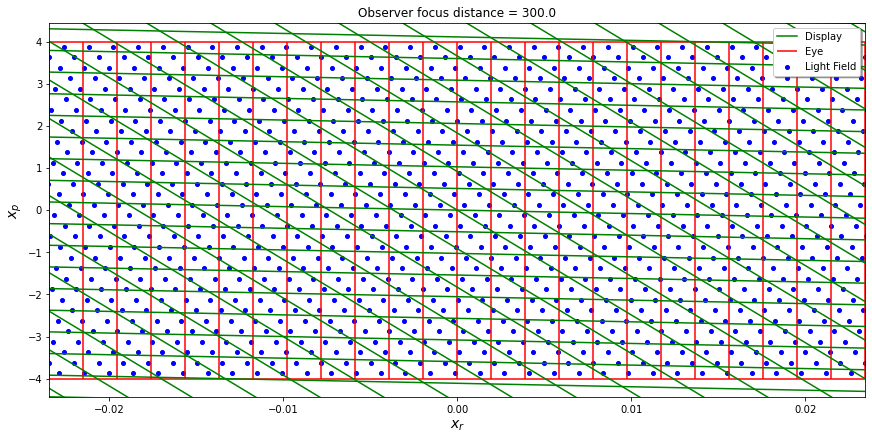

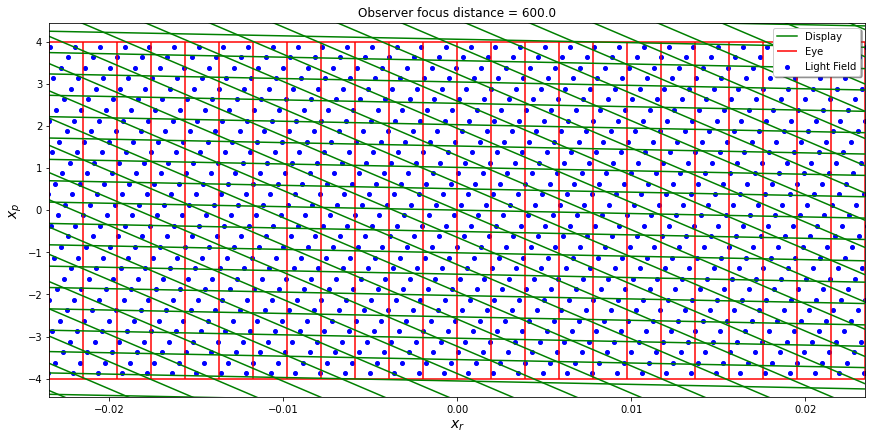

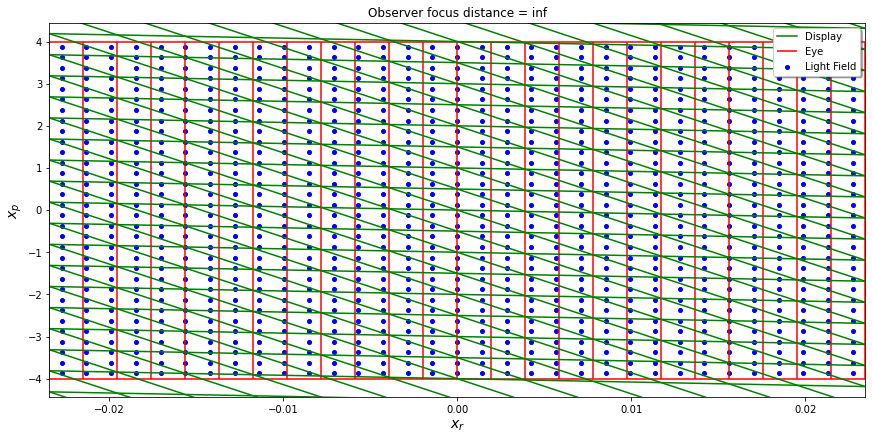

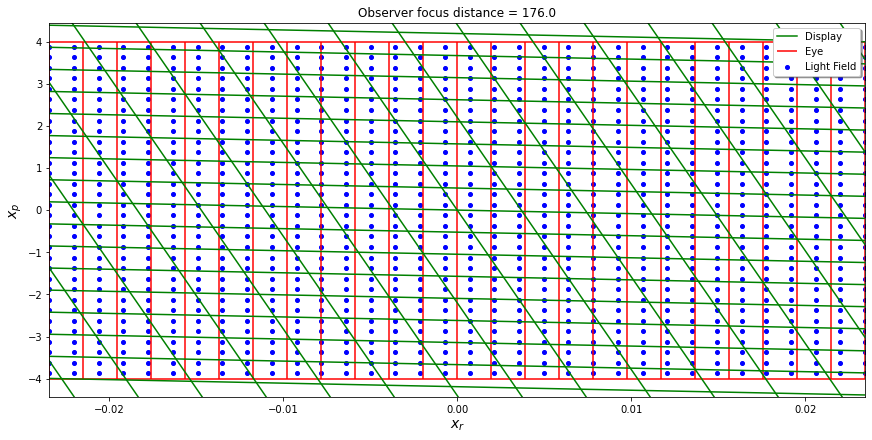

In [6]:
%%time
print('Plotting eye elements, display elements and light field samples in eye space...')

def plot_eye_space(x_r, x_p, x_v, x_a, x_b, pitch_r, size_p, pitch_a, pitch_b, z_v, z_a, z_b, z_f):
    fig, ax = pyplot.subplots(1, constrained_layout=True, figsize=(12, 6))

    ax.set_xlabel(r'$x_r$', fontsize=14)
    ax.set_ylabel(r'$x_p$', fontsize=14)

    ax.set_xlim(-pitch_r * 12, pitch_r * 12)
    ax.set_ylim(-size_p/1.8, size_p/1.8)

    ax.set_title('Observer focus distance = {}'.format(z_f))
    
    # Eye elements.
    ax.hlines([-size_p/2, size_p/2], x_r[0] - pitch_r/2, x_r[-1] + pitch_r/2, color='r', label='Eye')
    ax.vlines(x_r[0] - pitch_r/2, -size_p/2, size_p/2, color='r')
    ax.vlines(x_r + pitch_r/2, -size_p/2, size_p/2, color='r')

    # Display elements.
    x_p, x_v = np.broadcast_arrays(x_p.reshape(-1, 1), x_v.reshape(1, -1))
    x_r_from_pv = pv_to_r(x_p, x_v, z_v, z_f)

    ax.plot(ab_to_r(x_a[0] - pitch_a/2, np.array([[-0.5], [0.5]])*len(x_b)*pitch_b, z_a, z_b, z_f), ab_to_p(x_a[0] - pitch_a/2, np.array([[-0.5], [0.5]])*len(x_b)*pitch_b, z_a, z_b), color='g', label='Display')
    ax.plot(ab_to_r(x_a + pitch_a/2, np.array([[-0.5], [0.5]])*len(x_b)*pitch_b, z_a, z_b, z_f), ab_to_p(x_a + pitch_a/2, np.array([[-0.5], [0.5]])*len(x_b)*pitch_b, z_a, z_b), color='g')

    ax.plot(ab_to_r(np.array([[-0.5], [0.5]])*len(x_a)*pitch_a, x_b[0] - pitch_b/2, z_a, z_b, z_f), ab_to_p(np.array([[-0.5], [0.5]])*len(x_a)*pitch_a, x_b[0] - pitch_b/2, z_a, z_b), color='g')
    ax.plot(ab_to_r(np.array([[-0.5], [0.5]])*len(x_a)*pitch_a, x_b + pitch_b/2, z_a, z_b, z_f), ab_to_p(np.array([[-0.5], [0.5]])*len(x_a)*pitch_a, x_b + pitch_b/2, z_a, z_b), color='g')

    # Light Field samples.
    ax.scatter(x_r_from_pv.flat, x_p.flat, s=16, color='b', label='Light Field')

    # Legend
    ax.legend(loc='upper right', shadow=True)


for z_f in focus_distances:
    plot_eye_space(x_r, x_p, x_v, x_a, x_b, pitch_r, size_p, pitch_a, pitch_b, z_v, z_a, z_b, z_f)
    
plot_eye_space(x_r, x_p, x_v, x_a, x_b, pitch_r, size_p, pitch_a, pitch_b, z_v, z_a, z_b, z_v)

Plotting display elements and φ in eye space...
Wall time: 333 ms


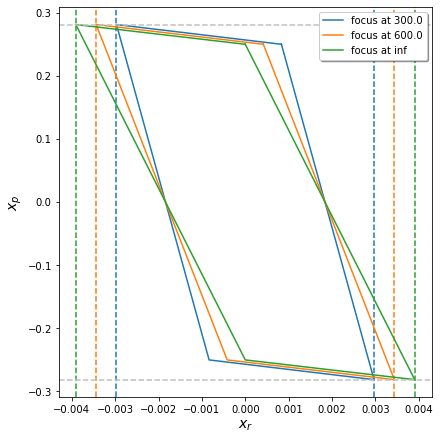

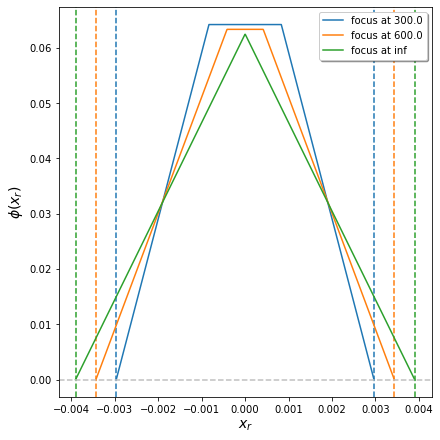

In [7]:
%%time
print('Plotting display elements and φ in eye space...')

def plot_elem_sizes(pitch_a, pitch_b, z_a, z_b, focus_distances):
    fig, ax = pyplot.subplots(1, constrained_layout=True, figsize=(6, 6))

    ax.set_xlabel(r'$x_r$', fontsize=14)
    ax.set_ylabel(r'$x_p$', fontsize=14)

    x_a = np.array([1, -1, -1,  1, 1]) * pitch_a/2
    x_b = np.array([1,  1, -1, -1, 1]) * pitch_b/2

    for z_f in focus_distances:
        elem_size_r = compute_elem_size_r(pitch_a, pitch_b, z_a, z_b, z_f)
        l = ax.plot(ab_to_r(x_a, x_b, z_a, z_b, z_f), ab_to_p(x_a, x_b, z_a, z_b), label='focus at {}'.format(z_f))
        ax.axvline(-elem_size_r/2, color=l[0].get_color(), linestyle='--')
        ax.axvline( elem_size_r/2, color=l[0].get_color(), linestyle='--')

    elem_size_p = compute_elem_size_p(pitch_a, pitch_b, z_a, z_b)
    ax.axhline(-elem_size_p/2, color='silver', linestyle='--')
    ax.axhline( elem_size_p/2, color='silver', linestyle='--')

    # Legend
    ax.legend(loc='upper right', shadow=True)

def plot_phi(pitch_a, pitch_b, size_p, z_a, z_b, focus_distances):
    fig, ax = pyplot.subplots(1, constrained_layout=True, figsize=(6, 6))

    ax.set_xlabel(r'$x_r$', fontsize=14)
    ax.set_ylabel(r'$\phi(x_r)$', fontsize=14)

    for z_f in focus_distances:
        elem_size_r = compute_elem_size_r(pitch_a, pitch_b, z_a, z_b, z_f)
        x_r = cp.linspace(-elem_size_r/2, elem_size_r/2, num=1024)
        l = ax.plot(x_r.get(), compute_phi(x_r, 0.0, 0.0, pitch_a, pitch_b, size_p, z_a, z_b, z_f).get(), label='focus at {}'.format(z_f))
        ax.axvline(-elem_size_r/2, color=l[0].get_color(), linestyle='--')
        ax.axvline( elem_size_r/2, color=l[0].get_color(), linestyle='--')

    ax.axhline(0.0, color='silver', linestyle='--')

    # Legend
    ax.legend(loc='upper right', shadow=True)



plot_elem_sizes(pitch_a, pitch_b, z_a, z_b, focus_distances)
plot_phi(pitch_a, pitch_b, size_p, z_a, z_b, focus_distances)

Selecting display elements that may intersect the separable eye square box...
Total elements per axis: 48 × 560 = 26880
Separable selected elements per axis: 8864
Wall time: 3.55 s


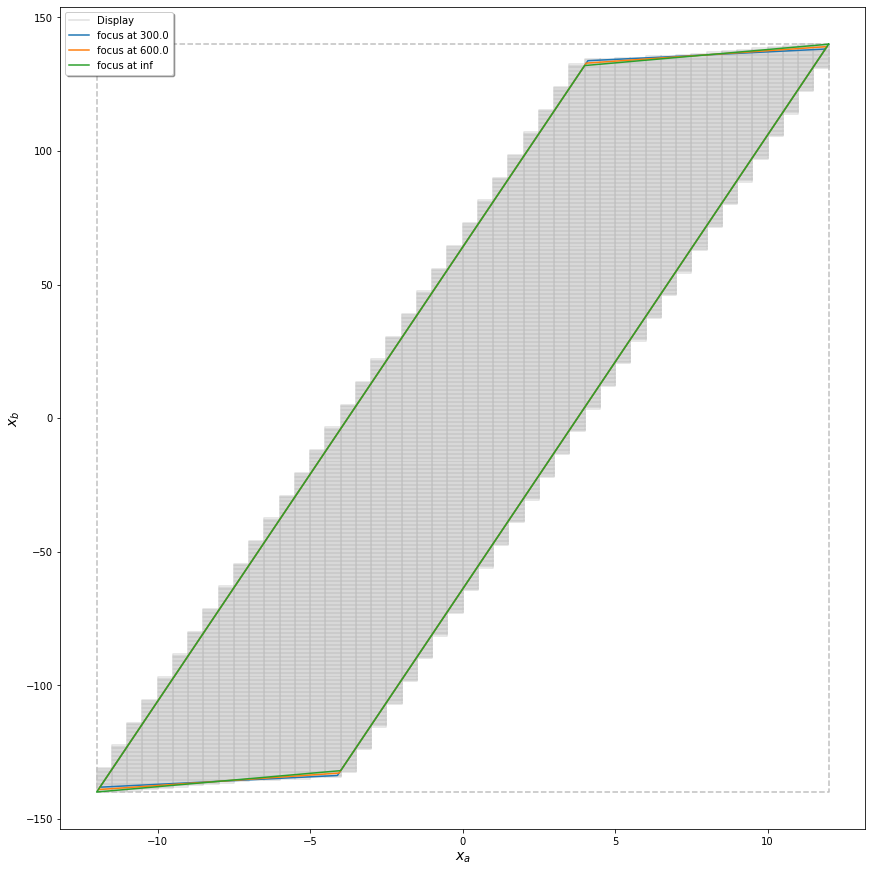

In [8]:
%%time
print('Selecting display elements that may intersect the separable eye square box...')

def compute_xx_ab(x_a, x_b, pitch_a, pitch_b, size_r, size_p, z_a, z_b, focus_distances):
    # Display element sizes in eye space.
    elem_size_r = cp.array(compute_elem_size_r(pitch_a, pitch_b, z_a, z_b, focus_distances)).reshape(-1, 1, 1)
    elem_size_p = cp.array(compute_elem_size_p(pitch_a, pitch_b, z_a, z_b)).reshape(-1, 1, 1)
    # Focus distances.
    z_f_from_fab = cp.array(focus_distances).reshape(-1, 1, 1)
    # Sample coordinates.
    x_a_from_fab = cp.array(x_a).reshape(1, -1, 1)
    x_b_from_fab = cp.array(x_b).reshape(1, 1, -1)
    # Transform to eye space.
    x_p_from_fab = ab_to_p(x_a_from_fab, x_b_from_fab, z_a, z_b)
    x_r_from_fab = ab_to_r(x_a_from_fab, x_b_from_fab, z_a, z_b, z_f_from_fab)
    # Closest border to origin.
    closest_r = cp.abs(x_r_from_fab) - elem_size_r/2
    closest_p = cp.abs(x_p_from_fab) - elem_size_p/2
    # Test (conservatively) for elements strictly outside the eye box.
    out_of_retina = cp.all(closest_r > size_r/2, axis=0)
    out_of_pupil = cp.all(closest_p > size_p/2, axis=0)
    out_of_eye = cp.logical_or(out_of_retina, out_of_pupil)
    # Return the indices of elements that may intersect the eye box.
    indices_a, indices_b = cp.nonzero(cp.logical_not(out_of_eye))
    return np.stack((x_a[indices_a.get()], x_b[indices_b.get()]), axis=-1)

def plot_display_elements(xx_ab, pitch_a, pitch_b, size_a, size_b, size_r, size_p, z_a, z_b, focus_distances):
    fig, ax = pyplot.subplots(1, constrained_layout=True, figsize=(12, 12))

    ax.set_xlabel(r'$x_a$', fontsize=14)
    ax.set_ylabel(r'$x_b$', fontsize=14)

    box_h = np.array([1, -1, -1,  1, 1]) / 2
    box_v = np.array([1,  1, -1, -1, 1]) / 2

    ax.plot(box_h * size_a, box_v * size_b, color='silver', linestyle='--')
    ax.plot(xx_ab[:, 0] + box_h.reshape(-1, 1) * pitch_a, xx_ab[:, 1] + box_v.reshape(-1, 1) * pitch_b, alpha=0.5, color='silver')[0].set_label('Display')

    for z_f in focus_distances:
        ax.plot(rp_to_d(box_h * size_r, box_v * size_p, z_a, z_f), rp_to_d(box_h * size_r, box_v * size_p, z_b, z_f), label='focus at {}'.format(z_f))

    # Legend
    ax.legend(loc='upper left', shadow=True)



xx_ab = compute_xx_ab(x_a, x_b, pitch_a, pitch_b, fov_factor, size_p, z_a, z_b, focus_distances)
n_ab = len(xx_ab)

print('Total elements per axis: {} × {} = {}'.format(n_a, n_b, n_a*n_b))
print('Separable selected elements per axis: {}'.format(n_ab))

plot_display_elements(xx_ab, pitch_a, pitch_b, size_a, size_b, fov_factor, size_p, z_a, z_b, focus_distances)

In [ ]:
%%time
print('Computing reference retina images...')

def lf_to_retina(x_r, x_p, x_v, pitch_r, z_v, z_f):
    # Sample coordinates.
    x_r = cp.array(x_r).reshape(-1, 1, 1)
    x_p = cp.array(x_p).reshape(1, -1, 1)
    x_v = cp.array(x_v).reshape(1, 1, -1)
    # Transform from light field space to retina space.
    x_r_from_pv = pv_to_r(x_p, x_v, z_v, z_f)
    # Identify incident rays.
    incidence = (cp.abs(x_r - x_r_from_pv) <= pitch_r/2).astype(cp.float32)
    # Count incident rays for each display element.
    count = cp.maximum(cp.sum(incidence, axis=(-1, -2), keepdims=True), 1.0)
    # Return incidence normalized by the number of incident rays.
    return cp.divide(incidence, count, out=incidence)

    

retina_image = np.zeros((3, n_r, n_r), dtype=np.float32)

light_field = zarr.open('data/sponza_sampled.zarr', mode='r')

temp = cp.zeros((3, n_p, n_v, n_r), dtype=cp.float32)
with tqdm(total=n_f*(n_p+1)) as pbar:
    for index_f, z_f in enumerate(focus_distances):
        transform = lf_to_retina(x_r, x_p, x_v, pitch_r, z_v, z_f).reshape(n_r, n_p*n_v)
        # Vertical pass.
        for index_p in range(n_p):
            temp[:, index_p] = cp.array(light_field[:, index_p].reshape(3, n_v, n_p*n_v)) @ transform.T
            pbar.update()
        # Horizontal pass.
        retina_image = (transform @ temp.reshape(3, n_p*n_v, n_r)).get()
        pbar.update()
        # Free GPU memory
        del transform
        mempool.free_all_blocks()

        print(' \n \nObserver focus distance =', z_f)
        array_stats(retina_image)
        display_image(retina_image)
# Free GPU memory
del temp
mempool.free_all_blocks()

In [ ]:
%%time
print('Computing naive coefficients...')

def lf_to_naive(xx_ab, x_p, x_v, pitch_a, pitch_b, z_a, z_b, z_v):
    # Sample coordinates.
    x_a = cp.array(xx_ab[:, 0]).reshape(-1, 1, 1)
    x_b = cp.array(xx_ab[:, 1]).reshape(-1, 1, 1)
    x_p = cp.array(x_p).reshape(1, -1, 1)
    x_v = cp.array(x_v).reshape(1, 1, -1)
    # Transform from light field space to display space.
    x_a_from_pv = (1 - z_a/z_v) * x_p + (z_a/z_v) * x_v
    x_b_from_pv = (1 - z_b/z_v) * x_p + (z_b/z_v) * x_v
    # Identify incident rays.
    incidence = cp.logical_and(cp.abs(x_a - x_a_from_pv) <= pitch_a/2, cp.abs(x_b - x_b_from_pv) <= pitch_b/2).astype(cp.float32)
    # Count incident rays for each display element.
    count = cp.maximum(cp.sum(incidence, axis=(-1, -2), keepdims=True), 1.0)
    # Return incidence normalized by the number of incident rays.
    return cp.divide(incidence, count, out=incidence)

    

naive = zarr.open('data/sponza_naive.zarr', mode='w', shape=(3, n_ab, n_ab), chunks=(1, n_ab, n_ab), dtype=np.float32)

light_field = zarr.open('data/sponza_sampled.zarr', mode='r')

temp = cp.zeros((n_p, n_v, n_ab), dtype=np.float32)
with tqdm(total=3*(n_p+1)) as pbar:
    transform = lf_to_naive(xx_ab, x_p, x_v, pitch_a, pitch_b, z_a, z_b, z_v).reshape(n_ab, n_p*n_v)
    for index_c in range(3):
        # Vertical pass.
        for index_p in range(n_p):
            temp[index_p] = cp.array(light_field[index_c, index_p].reshape(n_v, n_p*n_v)) @ transform.T
            pbar.update()
        # Horizontal pass.
        naive[index_c] = (transform @ temp.reshape(n_p*n_v, n_ab)).get()
        pbar.update()
    # Free GPU memory
    del transform
    mempool.free_all_blocks()
# Free GPU memory
del temp
mempool.free_all_blocks()

array_stats(naive)
display_image(naive[:, ::10, ::10])

In [ ]:
%%time
print('Computing naive retina images...')

def display_to_retina(x_r, xx_ab, pitch_a, pitch_b, size_p, z_a, z_b, z_f):
    # Sample coordinates.
    x_r = cp.array(x_r).reshape(-1, 1)
    x_a = cp.array(xx_ab[:, 0]).reshape(1, -1)
    x_b = cp.array(xx_ab[:, 1]).reshape(1, -1)
    # Return φ.
    return compute_phi(x_r, x_a, x_b, pitch_a, pitch_b, size_p, z_a, z_b, z_f)

    

naive = zarr.open('data/sponza_naive.zarr', mode='r')

for index_f, z_f in enumerate(focus_distances):
    transform = display_to_retina(x_r, xx_ab, pitch_a, pitch_b, size_p, z_a, z_b, z_f)
    retina_image = (transform @ cp.array(naive) @ transform.T).get()
    # Free GPU memory
    del transform
    mempool.free_all_blocks()

    print(' \n \nObserver focus distance =', z_f)
    array_stats(retina_image)
    display_image(retina_image)

In [ ]:
%%time
print('Computing projection ΦᵀR...')

def lf_to_display(xx_ab, x_p, x_v, pitch_a, pitch_b, size_r, size_p, z_v, z_a, z_b, z_f):
    # Allocate result.
    result = cp.zeros((len(xx_ab), len(x_p), len(x_v)))
    # Sample coordinates.
    x_a = cp.array(xx_ab[:, 0]).reshape(-1, 1, 1)
    x_b = cp.array(xx_ab[:, 1]).reshape(-1, 1, 1)
    x_p = cp.array(x_p).reshape(1, -1, 1)
    x_v = cp.array(x_v).reshape(1, 1, -1)
    # Transform to retina space.
    x_r_from_ab = ab_to_r(x_a, x_b, z_a, z_b, z_f)
    x_r_from_pv = pv_to_r(x_p, x_v, z_v, z_f)
    # Compute φ.
    for index_p in range(n_p):
        result[:, index_p, :] = compute_phi(x_r_from_pv[:, index_p, :], x_a[:, 0, :], x_b[:, 0, :], pitch_a, pitch_b, size_p, z_a, z_b, z_f)
    # Projection bounds.
    elem_size_r = compute_elem_size_r(pitch_a, pitch_b, z_a, z_b, z_f)
    lower_bound = cp.clip(x_r_from_ab - elem_size_r/2, -size_r/2, size_r/2)
    upper_bound = cp.clip(x_r_from_ab + elem_size_r/2, -size_r/2, size_r/2)
    # Projection size.
    size = upper_bound - lower_bound
    # Multiply φ values by the projection size.
    cp.multiply(result, size, out=result)
    # Count contributing rays for each display element.
    count = cp.count_nonzero(result, axis=(1, 2)).astype(cp.float32)
    cp.maximum(count, 1.0, out=count)
    # Return φ divided by the number of contributing rays.
    return cp.divide(result, count.reshape(-1, 1, 1), out=result)



projection = zarr.open('data/sponza_projection.zarr', mode='w', shape=(n_f, 3, n_ab, n_ab), chunks=(1, 1, n_ab, n_ab), dtype=np.float32)

light_field = zarr.open('data/sponza_sampled.zarr', mode='r')

temp = cp.zeros((n_p, n_v, n_ab), dtype=np.float32)
with tqdm(total=n_f*3*(n_p+1)) as pbar:
    for index_f, z_f in enumerate(focus_distances):
        transform = lf_to_display(xx_ab, x_p, x_v, pitch_a, pitch_b, fov_factor, size_p, z_v, z_a, z_b, z_f).reshape(n_ab, n_p*n_v)        
        for index_c in range(3):
            # Vertical pass.
            for index_p in range(n_p):
                temp[index_p] = cp.array(light_field[index_c, index_p].reshape(n_v, n_p*n_v)) @ transform.T
                pbar.update()
            # Horizontal pass.
            projection[index_f, index_c] = (transform @ temp.reshape(n_p*n_v, n_ab)).get()
            pbar.update()
        # Free GPU memory
        del transform
        mempool.free_all_blocks()
        
        print(' \n \nObserver focus distance =', z_f)
        array_stats(projection[index_f])
        display_image(projection[index_f, :, ::10, ::10] / np.amax(projection[index_f]))
# Free GPU memory
del temp
mempool.free_all_blocks()

In [ ]:
%%time
print('Computing autocorrelation ΦᵀΦ...')

def compute_autocorrelation(xx_ab, pitch_a, pitch_b, size_r, size_p, z_a, z_b, z_f):
    # Display element size in the retina.
    elem_size_r = compute_elem_size_r(pitch_a, pitch_b, z_a, z_b, z_f)
    # Sample coordinates.
    x_a = cp.array(xx_ab[:, 0])
    x_b = cp.array(xx_ab[:, 1])
    # Transform to retina space.
    x_r_from_ab = ab_to_r(x_a, x_b, z_a, z_b, z_f)
    # Rows and columns.
    out_x_r = x_r_from_ab.reshape(-1, 1)
    in_x_r  = x_r_from_ab.reshape(1, -1)
    # Retina bounds.
    lower_bound = cp.array(-size_r/2, dtype=cp.float32)
    upper_bound = cp.array( size_r/2, dtype=cp.float32)
    # Clip against left display element projection.
    lower_bound = cp.clip(lower_bound, out_x_r - elem_size_r/2, out_x_r + elem_size_r/2)
    upper_bound = cp.clip(upper_bound, out_x_r - elem_size_r/2, out_x_r + elem_size_r/2)
    # Clip against right display element projection.
    lower_bound = cp.clip(lower_bound, in_x_r - elem_size_r/2, in_x_r + elem_size_r/2)
    upper_bound = cp.clip(upper_bound, in_x_r - elem_size_r/2, in_x_r + elem_size_r/2)
    # Size of the projections overlap.
    size = upper_bound - lower_bound
    # Identify non-zero overlaps.
    indices_out, indices_in = cp.nonzero(size)
    # Sample the overlaps.
    x_r = lower_bound[indices_out, indices_in] + size[indices_out, indices_in] * cp.linspace(0.0, 1.0, num=100).reshape(-1, 1)
    # Compute φ for both elements.
    phi_out = compute_phi(x_r, x_a[indices_out], x_b[indices_out], pitch_a, pitch_b, size_p, z_a, z_b, z_f)
    phi_in  = compute_phi(x_r, x_a[indices_in ], x_b[indices_in ], pitch_a, pitch_b, size_p, z_a, z_b, z_f)
    # Compute and return the autocorrelation.
    autocorrelation = cp.zeros_like(size)
    autocorrelation[indices_out, indices_in] = cp.average(phi_out * phi_in, axis=0) * size[indices_out, indices_in]
    return autocorrelation



autocorrelation = zarr.open('data/sponza_autocorrelation.zarr', mode='w', shape=(n_f, n_ab, n_ab), chunks=(1, n_ab, n_ab), dtype=np.float32)

with tqdm(total=n_f) as pbar:
    for index_f, z_f in enumerate(focus_distances):
        autocorrelation[index_f] = compute_autocorrelation(xx_ab, pitch_a, pitch_b, fov_factor, size_p, z_a, z_b, z_f).get()
        mempool.free_all_blocks()
        pbar.update()

        print(' \n \nObserver focus distance =', z_f)
        array_stats(autocorrelation[index_f])
        display_image(autocorrelation[index_f, ::10, ::10] / np.amax(autocorrelation[index_f]))

In [ ]:
%%time
print('Computing optimum coefficients...')

rng = cp.random.default_rng()

optimum = zarr.open('data/sponza_optimum.zarr', mode='w', shape=(n_f, 3, n_ab, n_ab), chunks=(1, 1, n_ab, n_ab), dtype=np.float32)

projection = zarr.open('data/sponza_projection.zarr', mode='r')
autocorrelation = zarr.open('data/sponza_autocorrelation.zarr', mode='r')

with tqdm(total=n_f*3*10) as pbar:
    for index_f, z_f in enumerate(focus_distances):
        transform = cp.array(autocorrelation[index_f])
        for index_c in range(3):
            coefficients = 1.0 - rng.random((n_ab, n_ab), dtype=cp.float32)
            for index_k in range(10):
                temp = transform @ coefficients @ transform.T
                cp.add(temp, cp.finfo(cp.float32).eps, out=temp)
                cp.divide(cp.array(projection[index_f, index_c]), temp, out=temp)
                cp.multiply(coefficients, temp, out=coefficients)
                #cp.clip(coefficients, 0.0, 100.0, out=coefficients)
                pbar.update()
            optimum[index_f, index_c] = coefficients.get()
            # Free GPU memory
            del coefficients
            del temp
            mempool.free_all_blocks()
        # Free GPU memory
        del transform
        mempool.free_all_blocks()

        print(' \n \nObserver focus distance =', z_f)
        array_stats(optimum[index_f])
        display_image(optimum[index_f, :, ::10, ::10] / np.amax(optimum[index_f]))

array_stats(optimum)

In [ ]:
print('[Optimum NEAR retina images]')

optimum = zarr.open('data/sponza_optimum.zarr', mode='r')

for index_f, z_f in enumerate(focus_distances):
    transform = display_to_retina(x_r, xx_ab, z_a, z_b, z_f, pitch_a, pitch_b, size_p)
    retina_image = (transform @ cp.array(optimum[0]) @ transform.T).get()
    # Free GPU memory
    del transform
    mempool.free_all_blocks()

    print(' \n \nObserver focus distance =', z_f)
    array_stats(retina_image)
    display_image(retina_image)
    display_image(retina_image / np.amax(retina_image))

In [ ]:
print('[Optimum FAR retina images]')

optimum = zarr.open('data/sponza_optimum.zarr', mode='r')

for index_f, z_f in enumerate(focus_distances):
    transform = display_to_retina(x_r, xx_ab, z_a, z_b, z_f, pitch_a, pitch_b, size_p)
    retina_image = (transform @ cp.array(optimum[1]) @ transform.T).get()
    # Free GPU memory
    del transform
    mempool.free_all_blocks()

    print(' \n \nObserver focus distance =', z_f)
    array_stats(retina_image)
    display_image(retina_image)
    display_image(retina_image / np.amax(retina_image))